In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series, DataFrame
%matplotlib inline

Сделать новый файл с матчами

In [2]:
all_matches = pd.read_json("storage/results.json" )
all_matches["score_h"] = all_matches["score"].apply( lambda x: int (x.split(":")[0] )  ) 
all_matches["score_a"] = all_matches["score"].apply( lambda x: int (x.split(":")[1] )  ) 
all_matches["total_sum"] = all_matches["score_h"] + all_matches["score_a"]
del all_matches["score"]
del all_matches["id"]
del all_matches["quarters"]
del all_matches["gandicap"]

In [3]:
team_info = all_matches.copy()
team_info["delta"] = team_info["total_sum"] - team_info["total"]
team_info = team_info.reset_index(drop=True)
teams = sorted ( all_matches['home'].unique() )

pd.options.mode.chained_assignment = None 
def get_team_chrono_delta(team_name, curr_total):    
    team_stat = team_info[ (team_info['home'] == team_name) | (team_info['away'] == team_name )]
    team_stat['date'] = team_stat['date'].apply( lambda x: x.date() )  
    # team_stat = team_stat.set_index('date')
    team_stat = team_stat.sort_values(by=['date'])
    # ax = team_stat.plot.bar( y='total', ylim= [200, 250])
    bar_colors = [ 'tab:red' if float(i) < curr_total else 'tab:green' for i in team_stat['total']]
    ax = team_stat.plot.bar( y='delta', ylim= [-50, 50], title=team_name, legend=False, 
                            x = 'total', color=bar_colors, figsize=(10,4), grid=True, yticks=np.arange(-50,50, 10),
                           width=0.8)
    under_count = team_stat[ team_stat['delta'] < 0 ]['delta']
    over_count = team_stat[ team_stat['delta'] > 0 ]['delta']
    print(f"For {len(team_stat['date'])} matches {len(under_count)} under/{len(over_count)} over")
    

def get_team_chrono_delta_place(team_name, curr_total, place):    
    team_stat = team_info[ team_info[place] == team_name]
    team_stat['date'] = team_stat['date'].apply( lambda x: x.date() )  
    # team_stat = team_stat.set_index('date')
    team_stat = team_stat.sort_values(by=['date'])
    # ax = team_stat.plot.bar( y='total', ylim= [200, 250])
    bar_colors = [ 'tab:red' if float(i) < curr_total else 'tab:green' for i in team_stat['total']]
    ax = team_stat.plot.bar( y='delta', ylim= [-50, 50], title=team_name, legend=False, 
                            x = 'total', color=bar_colors, figsize=(10,4), grid=True, yticks=np.arange(-50,50, 10),
                           width=0.8)
    under_count = team_stat[ team_stat['delta'] < 0 ]['delta']
    over_count = team_stat[ team_stat['delta'] > 0 ]['delta']
    print(f"For {len(team_stat['date'])} matches {len(under_count)} under/{len(over_count)} over")
    
def my_map(old_value, old_min, old_max, new_min, new_max):
    new_value = ( (old_value - old_min) / (old_max - old_min) ) * (new_max - new_min) + new_min
    return new_value

def get_team_chrono_delta_place_odd(team_name, curr_total, place, current_odd ):    
    team_stat = team_info[ team_info[place] == team_name]
    team_stat['date'] = team_stat['date'].apply( lambda x: x.date() )  
    # team_stat = team_stat.set_index('date')
    team_stat = team_stat.sort_values(by=['date'])
    
    max_odd =  max(team_stat[f"odd_{place[0]}"])
    min_odd =  min(team_stat[f"odd_{place[0]}"])
    # print(min_odd, " - ", max_odd)
    
    if current_odd < min_odd:
        min_odd = max_odd
    elif current_odd > max_odd:
        max_odd = min_odd
    elif current_odd - min_odd > max_odd - current_odd:
        max_odd += 2 * current_odd - min_odd - max_odd
    elif current_odd - min_odd < max_odd - current_odd:
        min_odd -= max_odd + min_odd - 2 * current_odd
    def left_b(odd):
        return (0.1, my_map(odd, min_odd, current_odd, 0.0, 1.0), 0.7)
    def right_b(odd):
        return (0.1, my_map(odd, max_odd, current_odd, 0.0, 1.0), 0.7)
    
        
    
    bar_colors = [ left_b(i) if i <= current_odd else right_b(i)  for i in team_stat[f"odd_{place[0]}"]]
    ax = team_stat.plot.bar( y='delta', ylim= [-50, 50], title=team_name, legend=False, 
                            x = 'total', color=bar_colors, figsize=(10,4), grid=True, yticks=np.arange(-50,50, 10),
                           width=0.8)
    under_count = team_stat[ team_stat['delta'] < 0 ]['delta']
    over_count = team_stat[ team_stat['delta'] > 0 ]['delta']
    return f"{len(under_count)} under/{len(over_count)} over"
    # print(f"For {len(team_stat['date'])} matches {len(under_count)} under/{len(over_count)} over")
    
def get_team_chrono_odd(team_name):    
    team_stat = team_info[ (team_info['home'] == team_name) | (team_info['away'] == team_name )]
    team_stat['date'] = team_stat['date'].apply( lambda x: x.date() )  
    
    team_stat['odd'] = team_stat['odd_a'].where( team_stat['away'] == team_name, team_stat['odd_h'])
    
    max_val = max(team_stat['odd'])
    min_val = min(team_stat['odd'])
    
    team_stat['result'] = "WIN"
    team_stat['result'] = team_stat['result'].where((( team_stat['home'] == team_name) & (team_stat['score_h'] > team_stat['score_a'] )) 
                                                  | (( team_stat['away'] == team_name) & (team_stat['score_a'] > team_stat['score_h'] )) , "LOSE")
    
    team_stat = team_stat.sort_values(by=['date'])       
        
    bar_colors = [ 'tab:red' if  h == "LOSE"   else 'tab:green' for h in team_stat['result']]
    y_high = max_val + max_val * 0.1
    y_low = min_val - min_val * 0.1
    ax = team_stat.plot.bar( y='odd', ylim= [y_low, y_high], title=team_name, legend=False, 
                            x = 'date', color=bar_colors, figsize=(10,4), grid=True, yticks=np.arange(y_low,y_high, (y_high - y_low) / 6),
                           width=0.8)
    print(team_stat['odd'].describe())

def get_team_chrono_odd_place(team_name, place):    
    team_stat = team_info[ (team_info[place] == team_name)]
    team_stat['date'] = team_stat['date'].apply( lambda x: x.date() )  
    
    team_stat['odd'] = team_stat['odd_a'].where( team_stat['away'] == team_name, team_stat['odd_h'])
    
    max_val = max(team_stat['odd'])
    min_val = min(team_stat['odd'])
    
    team_stat['result'] = "WIN"
    team_stat['result'] = team_stat['result'].where((( team_stat['home'] == team_name) & (team_stat['score_h'] > team_stat['score_a'] )) 
                                                  | (( team_stat['away'] == team_name) & (team_stat['score_a'] > team_stat['score_h'] )) , "LOSE")
    
    team_stat = team_stat.sort_values(by=['date'])       
        
    # bar_colors = [ 'tab:red' if  h == "LOSE"   else 'tab:green' for h in team_stat['result']]
    # y_high = max_val + max_val * 0.1
    # y_low = min_val - min_val * 0.1
    # ax = team_stat.plot.bar( y='odd', ylim= [y_low, y_high], title=team_name, legend=False, 
    #                         x = 'date', color=bar_colors, figsize=(10,4), grid=True, yticks=np.arange(y_low,y_high, (y_high - y_low) / 6),
    #                        width=0.8)
    return(team_stat['odd'].describe())

In [4]:
total = all_matches.copy()
total["delta"] = total["total_sum"] - total["total"]
del total["date"]
total = total.reset_index(drop=True)

In [5]:
import matplotlib as mpl
import matplotlib.lines as mlines

def get_team( team_name ) :    
    home = total[total["home"] == team_name][["odd_h", "total", "delta" ]]
    home = home.rename(columns={"odd_h": "odd", "match_score" : "match"})

    away =  total[total["away"] == team_name][["odd_a", "total", "delta" ]]
    away = away.rename(columns={"odd_a": "odd", "match_score" : "match"})
    team = pd.concat([home,away]).reset_index(drop=True)
    return team

def get_team_place( team_name, place ) :    
    odd_name = "odd_h" if place == "home" else "odd_a"
    home = total[total[place] == team_name][[odd_name, "total", "delta" ]]
    home = home.rename(columns={odd_name: "odd", "match_score" : "match"})

    # away =  total[total["away"] == team_name][["odd_a", "total", "delta" ]]
    # away = away.rename(columns={"odd_a": "odd", "match_score" : "match"})
    team = home.reset_index(drop=True)
    return team

def get_fav( val ):
    if val >= 1.0 and val < 1.5 :
        return "HIGH"
    elif val >= 1.5 and val < 2.0 :
        return "MED"
    elif val >= 2.0 and val < 3.0 :
        return "LOW"
    elif val >= 3.0  :
        return "FEW"
    
def complete_match(home, away, total):
    team = get_team(home)
    team["fav"] = team["odd"].apply( lambda x : get_fav(x) )
    team['id'] = "home"    
    team2 = get_team(away)
    team2["fav"] = team2["odd"].apply( lambda x : get_fav(x) )
    team2['id'] = "away"
    # data=pd.concat([team, team2])
    
    ax = team.plot.scatter(x="total", y="delta", label=home,  c='odd', colormap='cool')
    ax1 = team2.plot.scatter(x="total", y="delta", label=away, c='odd', colormap='cool')
        
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    x_min1, x_max1 = ax1.get_xlim()   
    y_min1, y_max1 = ax1.get_ylim()

    ax.plot([float(total), float(total), float(total)], [y_min, 0, y_max], 'y', ls='--')
    ax.plot([x_min,x_max],[0, 0], 'y', ls='--')
    ax1.plot([float(total), float(total), float(total)], [y_min1, 0, y_max1], 'y', ls='--')
    ax1.plot([x_min1,x_max1],[0, 0], 'y', ls='--')    
    
def complete_match_place(home, away, total):
    team = get_team_place(home, "home")
    team["fav"] = team["odd"].apply( lambda x : get_fav(x) )
    team['id'] = "home"    
    team2 = get_team_place(away, "away")
    team2["fav"] = team2["odd"].apply( lambda x : get_fav(x) )
    team2['id'] = "away"
    # data=pd.concat([team, team2])
    
    ax = team.plot.scatter(x="total", y="delta", label=home,  c='odd', colormap='cool')
    ax1 = team2.plot.scatter(x="total", y="delta", label=away, c='odd', colormap='cool')
        
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    x_min1, x_max1 = ax1.get_xlim()   
    y_min1, y_max1 = ax1.get_ylim()

    ax.plot([float(total), float(total), float(total)], [y_min, 0, y_max], 'y', ls='--')
    ax.plot([x_min,x_max],[0, 0], 'y', ls='--')
    ax1.plot([float(total), float(total), float(total)], [y_min1, 0, y_max1], 'y', ls='--')
    ax1.plot([x_min1,x_max1],[0, 0], 'y', ls='--')  
    

Портленд Трэйл Блэйзерс Милуоки Бакс
9 under/16 over
14 under/9 over
with total 241.5 and odds: 2.49 :  1.54


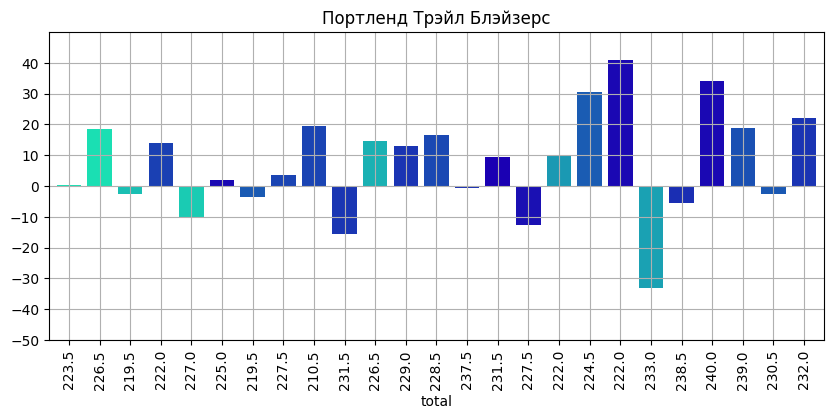

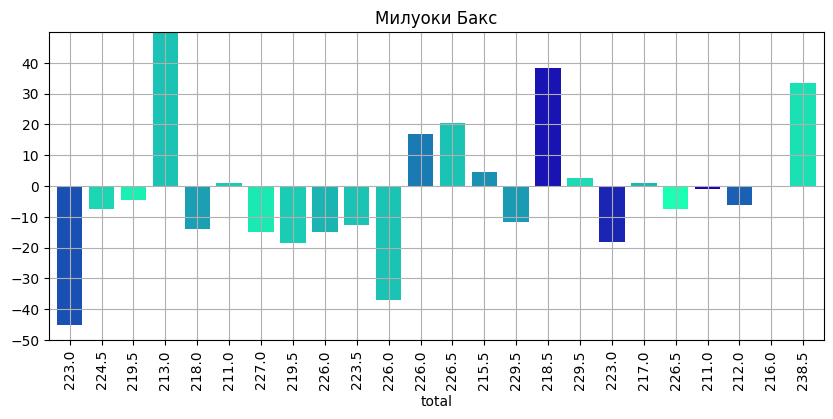

In [28]:
import datetime, json
import pandas as pd

today = pd.read_json("storage/today.json" )
del today["id"]
del today["gandicap"]

m = today.iloc[7]
home_res_str = get_team_chrono_delta_place_odd(m['home'], m['total'], 'home', m['odd_h'] )
away_res_str = get_team_chrono_delta_place_odd(m['away'], m['total'], 'away', m['odd_a'] )

print(  m['home'],  m['away'])
print(home_res_str)
print(away_res_str)
print( f"with total {m['total']} and odds: {m['odd_h']} :  {m['odd_a']}")

In [29]:
print( m['home'], m['odd_h'])
print(get_team_chrono_odd_place( m['home'], 'home' ))
print('===============================================')
print( m['away'], m['odd_a'])
print(get_team_chrono_odd_place( m['away'], 'away' ))
print('===============================================')

Портленд Трэйл Блэйзерс 2.49
count    25.000000
mean      1.714000
std       0.446514
min       1.220000
25%       1.460000
50%       1.560000
75%       1.980000
max       2.750000
Name: odd, dtype: float64
Милуоки Бакс 1.54
count    24.000000
mean      1.947500
std       0.476338
min       1.140000
25%       1.682500
50%       1.860000
75%       2.205000
max       2.900000
Name: odd, dtype: float64


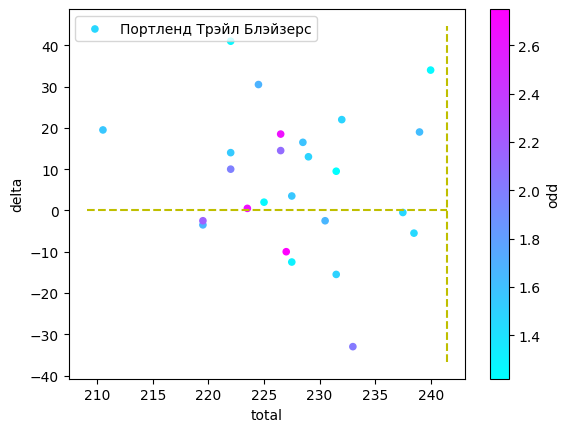

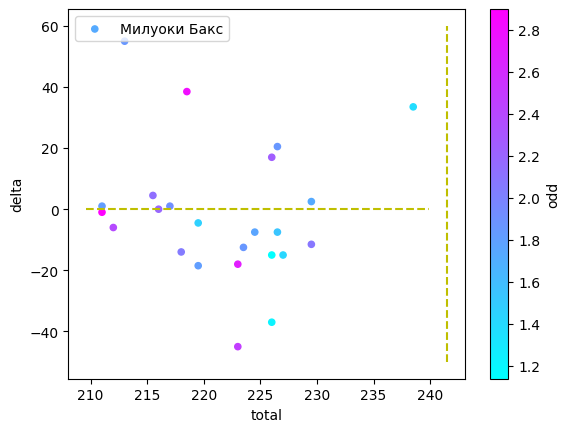

In [30]:
complete_match_place( m['home'], m['away'], m['total'] )

In [9]:
'''
Юта Даллас ТМ
ГС Оклахома


'''

'\n\n\n'